# The Quantum Approximate Optimization Algorithm

This notebook walks through the background/theory of the Quantum Approximate Optimization Algorithm [1] and implements QAOA for the Ising Hamiltonian.

## Requirements

For the QAOA implementation, this notebook requires:

* <a href="https://cirq.readthedocs.io/en/stable/">Cirq</a> v0.4.0.
* Numpy.
* Matplotlib.

In [1]:
"""Attempt to install Cirq from the notebook."""
#!pip install --upgrade pip
#!pip install cirq~=0.4.0

# Background and Theory

The problem that QAOA seeks to solve is maximizing or minimizing some cost function

\begin{equation} \label{eqn:cost-sum-over-clauses}
    C(\mathbf{z}) = \sum_{\alpha = 1}^{m} C_\alpha(\mathbf{z})
\end{equation}

written as a sum of $m$ clauses $C_\alpha(\mathbf{z})$ on bit strings $\mathbf{z} \in \{0, 1\}^n$, or equivalently spins $z_i \in \{-1, +1\}^n$ as there is a bijective map between the two. (Bits $z$ and spins $\sigma$ are related by the bijective mapping $\sigma = 2 z - 1 \iff z = (\sigma + 1) / 2$. Thus, any problem on bits and be framed as a problem on spins, and vice versa.)   

An example problem for which QAOA has been used is MaxCut on a regular graph, for which the cost function can be written in terms of spins as

\begin{equation}
    C(\mathbf{z}) = \frac{1}{2} \sum_{\langle i, j \rangle} w_{ij} ( 1 - z_i z_j )
\end{equation}

Here, the sum is over edges $\langle i, j \rangle$ in a graph, and each clause $w_{ij} (1 - z_i z_j)$ contributes a nonzero term to the cost if and only if the spins $z_i$ and $z_j$ are anti-aligned (i.e., have different values). 


By promoting each spin to a Pauli-$Z$ operator (which has eigenvalues $\pm 1$), the cost can be written as a <i>cost Hamiltonian</i>.

\begin{equation}
    C \equiv H_C = \frac{1}{2} \sum_{\langle i, j \rangle} w_{ij} ( I - \sigma_z^{(i)} \sigma_z^{(j)} )
\end{equation}

where $I$ is the identity operator and $\sigma_z^{(i)}$ denotes a Pauli-$Z$ operator on the $i$th spin. This cost Hamiltonian can easily be seen to be diagonal in the computational basis. This is the general input to the quantum approximate optimization algorithm, as we discuss below.

The prescription for QAOA is as follows. Given a cost Hamiltonian $H_C \equiv H$ of the form given above, define the unitary operator

\begin{equation}
    U(H_C, \gamma) := e^{- i \gamma H_C} = \prod_{\alpha = 1}^{m} e^{- i \gamma C_\alpha}
\end{equation}

which depends on the parameter $\gamma$. Note that the second line follows because each clause $C_\alpha$ is diagonal in the computational basis, hence $[C_\alpha, C_\beta] = 0$ for all $\alpha, \beta \in \{ 1, ..., m \}$. Further note that this can be interpreted, in light of the previous section, as simulating (i.e., evolving with) the cost Hamiltonian $H_C$ for a <i>time</i> $\gamma$. We can restrict the "time" to be between $0$ and $2 \pi$, however, since $C$ has integer values. Thus, we can equally think of the parameter $\gamma$ as an angle of rotation.

Next, define the operator $B \equiv H_B$, known as a <i>mixer Hamiltonian</i>, which is conventionally taken to be

\begin{equation}
    B \equiv H_B = \sum_{j = 1}^{n} \sigma_j^{(x)}
\end{equation}

where $\sigma_x^{(j)}$ is a Pauli-$X$ operator on spin $j$. From this, we form the unitary operator

\begin{equation}
    U(H_B, \beta) := e^{- i \beta B} = \prod_{j = 1}^{n} e^{- i \beta \sigma_j^{(x)}} .
\end{equation}

Note that the second line follows because all terms in the Hamiltonian commute with one another. We can view the term $e^{- i \beta \sigma_j^{(x)}}$ as a rotation about the $x$ axis on spin $j$ by angle $2 \beta$. Thus, we can restrict $0 \le \beta < \pi$. 

With these definitions, we can state the steps of QAOA:

(1) Start with an initial state that is an equal superposition over all bit strings (spins)
    
\begin{equation}
    |s\rangle = \frac{1}{\sqrt{2^n}} \sum_{z \in \{0, 1\}^n} |z\rangle 
\end{equation}

by applying a Hadamard to each qubit $H^{\otimes n} |0\rangle^{\otimes n}$. 

(2) Evolve with the cost Hamiltonian by implementing $U(H_C, \gamma)$ for an angle $\gamma$.

(3) Evolve with the mixer Hamiltonian by implementing $U(H_B, \beta)$ for an angle $\beta$. 

(4) Repeat steps (2) and (3) $p$ times with different parameters $\gamma_i, \beta_i$ at each step $i = 1, ..., p$ to form the state

\begin{equation} \label{eqn:qaoa-circuit-eqn}
    |\mathbf{\gamma}, \mathbf{\beta} \rangle := \prod_{i = 1}^{p} U(H_B, \beta_i) U(H_C, \gamma_i) |s\rangle .
\end{equation}

(5) Measure in the computational basis to compute the expectation of $H_C$ in this state:

\begin{equation} \label{eqn:qaoa-expectation}
    F_p(\mathbf{\gamma}, \mathbf{\beta}) := \langle \mathbf{\gamma}, \mathbf{\beta} | H_C | \mathbf{\gamma}, \mathbf{\beta} \rangle .
\end{equation}

(6) Use a (classical) optimization algorithm to (approximately) compute the maximum or minimum value of $F_p(\mathbf{\gamma}, \mathbf{\beta})$.

(7) Sample from the output distribution of the circuit with optimal parameters to get a set of bit strings $\mathbf{z}$. The most probable bit strings encode the approximate optimum for the cost function.


It can be shown using the adiabatic theorem of quantum computing that

\begin{equation}
    \lim_{p \rightarrow \infty} 
    \max_{\mathbf{\gamma}, \mathbf{\beta}} F_p(\mathbf{\gamma}, \mathbf{\beta}) 
    = \max_{z} C(z) .
\end{equation}

That is, given enough parameters $\gamma, \beta$, we can be sure the exact solution of the problem is attainable. The parameter $p$ can thus be considered a hyperparameter. One form of approximation in the quantum <i>approximate</i> optimization algorithm is the finite cutoff for $p$. Another form of approximation is the ability of the classical optimizer to find the optimum.

# Example Problem: The Ising Hamiltonian

To get a better idea of how QAOA works, we now turn to an implementation. In this example, we consider the transverse field Ising model as a cost Hamiltonian:

\begin{equation}
    H_C = - \sum_{\langle i, j\rangle} J_{ij} \sigma_z^{(i)} \sigma_z^{(j)} - \sum_{i} h_i \sigma_{i}^{(x)} .
\end{equation}

For simplicity of presentation, we set the transverse field coefficients to zero ($h_i = 0$) and set each interaction coefficient equal to one ($J_{ij} = 1$). The Hamiltonian can be modified in a straightforward way to account for the general problem, but these details are not important in a first encounter with QAOA. Another reason for this is that this system is trivial to solve analytically---thus, we can compare the solution found by QAOA to the exact solution. By making these simplifications, our cost Hamiltonian has the form 

\begin{equation}
    H_C = - \sum_{\langle i, j\rangle} \sigma_z^{(i)} \sigma_z^{(j)}
\end{equation}

The graph (i.e., arrangement of spins) we will consider is nearest neighbors on a 2D grid. We thus need a way to implement the unitary operator

\begin{equation}
    U(H_C, \gamma) := e^{-i H_C \gamma} = \prod_{\langle i, j\rangle} e^{i \gamma Z_i Z_j}
\end{equation}

where we will now write $\sigma_z^{(i)} = Z_i$ for simplicity. In order to implement this entire unitary, we need a sequence of gates for implementing each $e^{i \gamma Z_i Z_j}$ term, where $i$ and $j$ are neighbors in the graph. It will be convenient to rescale $\gamma$ and consider implementing the unitary $e^{i \pi \gamma Z_i Z_j}$. To understand how to do this, note that the operator $Z \otimes Z$ is diagonal in the computational basis, hence $e^{i \pi \gamma Z \otimes Z}$ is just the exponential of each diagonal element (multiplied by $i \pi \gamma$):

\begin{equation} \label{eqn:qaoa-mtx-to-implement}
    \exp(i \pi \gamma Z\otimes Z) = 
    \begin{bmatrix}
        e^{i \pi \gamma}  & 0  &0&0\\
        0 & e^{-i \pi \gamma}   &0&0\\
        0&0& e^{-i \pi \gamma}  &0 \\
        0&0 & 0  & e^{i \pi \gamma}
        \end{bmatrix} .
\end{equation}

To get some intuition about how to implement this operator in terms of standard gates, note that the controlled-$Z$ gate is diagonal with $C(Z) = \text{diag}(1, 1, 1, -1)$. Writing $-1 = e^{i \pi}$, we see that $C(Z) = \text{diag}(1, 1, 1, e^{i \pi})$, hence

\begin{equation}
    C(Z^\gamma) = \begin{bmatrix}
        1  & 0  &0&0\\
        0 & 1   &0&0\\
        0&0& 1  &0 \\
        0&0 & 0  & e^{i\pi \gamma}
    \end{bmatrix}
\end{equation}

This gives us one diagonal term in the final unitary that we want to implement. To get the other terms, we can apply $X$ operators on the appropriate qubits. For example,

\begin{equation}
    (I\otimes X)
    \begin{bmatrix}
        1  & 0  &0&0\\
        0 & 1   &0&0\\
        0&0& 1  &0 \\
        0&0 & 0  & e^{i\pi \gamma}
    \end{bmatrix}
    (I\otimes X)
    =
    \begin{bmatrix}
        1  & 0  &0&0\\
        0 & 1   &0&0\\
        0&0& e^{i\pi \gamma}  &0 \\
        0&0 & 0  & 1
    \end{bmatrix}
\end{equation}

We can continue in this fashion to get all four diagonal elements, then get the full unitary by simply multiplying them together (using the fact that the product of diagonal matrices is diagonal).

In the Cirq code below, we write a function which gives us a circuit for implementing the unitary $e^{-i \pi \gamma Z_i Z_j}$. We then test our function by printing out the circuit for an example set of qubits $i$ and $j$ with an arbitrary value of $\gamma$, and making sure the unitary matrix of this circuit is what we expect.

In [2]:
"""Imports."""
import numpy as np
import matplotlib.pyplot as plt

import cirq

# Building the QAOA Circuit

In [3]:
"""Function to implement the ZZ gate in the Ising Hamiltonian."""
def ZZ(a, b, gamma):
    """Returns a circuit implementing exp(i \pi \gamma Z_i Z_j)."""
    # Get a circuit
    circuit = cirq.Circuit()
    
    # Gives the fourth diagonal component
    circuit.append(cirq.CZ(a, b)**gamma) 
    
    # Gives the third diagonal component
    circuit.append([cirq.X(b), cirq.CZ(a,b)**(-1 * gamma), cirq.X(b)])
    
    # Gives the second diagonal component
    circuit.append([cirq.X(a), cirq.CZ(a,b)**-gamma, cirq.X(a)])
    
    # Gives the first diagonal component
    circuit.append([cirq.X(a), cirq.X(b), cirq.CZ(a,b)**gamma, 
                    cirq.X(a), cirq.X(b)])
    
    return circuit

The following function returns a circuit evolving with the cost Hamiltonian.

In [4]:
"""Function for evolving with the cost Hamiltonian."""
def cost_circuit(gamma):
    """Returns a circuit for evolving with the cost Hamiltonian."""
    circ = cirq.Circuit()
    for i in range(nrows):
        for j in range(ncols):
            if i < nrows - 1:
                circ += ZZ(qreg[i][j], qreg[i + 1][j], gamma)
            if j < ncols - 1:
                circ += ZZ(qreg[i][j], qreg[i][j + 1], gamma)

    return circ

We now write a function for implementing our "mixer" Hamiltonian with the standard QAOA ansatz.

In [5]:
"""Function for evolving with the mixer Hamiltonian."""
def mixer(beta):
    """Generator for U(H_B, beta) layer (mixing layer)"""
    for row in qreg:
        for qubit in row:
            yield cirq.X(qubit)**beta

And now we can write a function to build the entire QAOA circuit for $p$ layers. Here, the number of layers comes in from the length of the input lists of `gammas` and `betas`.

In [6]:
def qaoa(gammas, betas):
    """Returns a QAOA circuit."""
    circ = cirq.Circuit()
    
    # Prepare the initial state H|0>
    circ.append(cirq.H.on_each([q for row in qreg for q in row]))
    
    # Add the alternating mixer and cost Hamiltonian evolution circuits
    for i in range(len(gammas)):
        circ += cost_circuit(gammas[i])
        circ.append(mixer(betas[i]))
    
    return circ

# Simulating the Circuit and Computing the Cost

We'll cheat by getting explicit access to the wavefunction to compute the cost. First, we write a function that simulates the circuit and returns the wavefunction.

In [7]:
"""Function for simulating the circuit."""
def simulate(circ):
    """Returns the wavefunction after applying the circuit."""
    sim = cirq.Simulator()
    return sim.simulate(circ).final_state

Next, we can compute the energy from the wavefunction with the following function.

In [8]:
"""Helper function to compute the expectation of the cost Hamiltonian using the wavefunction."""
def energy_from_wavefunction(wf):
    """Computes the energy-per-site of the Ising Model from the wavefunction."""
    # Z is a (nsites x 2**nsites) array. Each row consists of the 
    # 2**nsites non-zero entries in the operator that is the Pauli-Z matrix on
    # one of the qubits times the identites on the other qubits. The (i*ncols + j)th
    # row corresponds to qubit (i,j).
    Z = np.array([(-1)**(np.arange(2**nsites) >> i) 
                for i in range(nsites-1,-1,-1)])

    # Create the operator corresponding to the interaction energy summed over all
    # nearest-neighbor pairs of qubits
    ZZ_filter = np.zeros_like(wf, dtype=float)
    for i in range(nrows):
        for j in range(ncols):
            if i < nrows-1:
                ZZ_filter += Z[i*ncols + j]*Z[(i+1)*ncols + j]
            if j < ncols-1:
                ZZ_filter += Z[i*ncols + j]*Z[i*ncols + (j+1)]
            
    # Expectation value of the energy divided by the number of sites
    return -np.sum(np.abs(wf)**2 * ZZ_filter) / nsites

And finally a function using these two helper functions for computing the cost directly from the `gamma` and `beta` parameter values.

In [9]:
"""Function for computing the cost from the parameters."""
def cost(gammas, betas):
    """Returns the cost function of the problem."""
    wavefunction = simulate(qaoa(gammas, betas))
    return energy_from_wavefunction(wavefunction)

# Finding the Best Parameters

Here we can use a simple grid search over a range of values for one layer of QAOA. This is not the most elegant solution and does not scale well for more parameters.

In [10]:
"""Function for doing a grid search over parameter values."""
def grid_search(gammavals, betavals):
    """Does a grid search over all parameter values and returns the costs.
    
    REQUIRES gammavals and betavals to have length 1.
    """
    costmat = np.zeros((len(gammavals), len(betavals)))
    
    for (i, gamma) in enumerate(gammavals):
        for (j, beta) in enumerate(betavals):
            costmat[i, j] = cost([gamma], [beta])

    return costmat

We can now set up the qubits and do the grid search.

In [11]:
"""Set up the qubits for this problem."""
ncols = 3
nrows = 3
nsites = nrows * ncols
qreg = [[cirq.GridQubit(i,j) for j in range(ncols)] for i in range(nrows)]

In [12]:
"""Do the grid search."""
ngammas = 50
nbetas = 75

gammavals = np.linspace(0, 1, ngammas)
betavals = np.linspace(0, np.pi, nbetas)

costmat = grid_search(gammavals, betavals)

Now we can visualize the cost landscape.

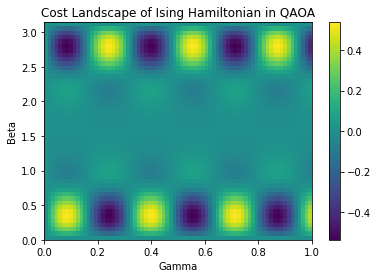

In [13]:
"""Visualizing the cost landscape."""
plt.imshow(costmat, extent=(0, 1, 0, np.pi), origin="lower", aspect="auto")
plt.title("Cost Landscape of Ising Hamiltonian in QAOA")
plt.xlabel("Gamma")
plt.ylabel("Beta")
plt.colorbar()
plt.show()

Note that the cost landscape has a lot of symmetries. This is typical in variational quantum algorithms.

We can now "manually" extract the best parameters and print out the minimum cost found, as follows:

In [14]:
"""Extracting the best parameters and minimum cost."""
# Coordinates from the grid of cost values
gamma_coord, beta_coord = np.where(costmat == np.min(costmat))

# Values from the coordinates
gamma_opt = gammavals[gamma_coord[0]]
beta_opt = betavals[beta_coord[0]]

# Display the optimal cost
print("Minimum cost =", cost([gamma_opt], [beta_opt]))

Minimum cost = -0.5375467536772097


# Sampling from the Circuit to get the Best Bit Strings

Now that we have the optimal parameters, we merely need to sample from the circuit instantiated with these parameters.

In [15]:
"""Helper function to get the bit strings from sampling the circuit."""
def get_bit_strings(gammas, betas, nreps=10000):
    """Measures the QAOA circuit in the computational basis to get bit strings."""
    circ = qaoa(gammas, betas)
    circ.append(cirq.measure(*[qubit for row in qreg for qubit in row], key='m'))
    
    # Simulate the circuit
    sim = cirq.Simulator()
    res = sim.run(circ, repetitions=nreps)
    
    return res

Now we use this function to sample from the circuit and get the most common bit strings.

In [16]:
"""Getting the most common bit strings from the QAOA circuit with optimal parameters."""
# Sample to get bits and convert to a histogram
bits = get_bit_strings([gamma_opt], [beta_opt])
hist = bits.histogram(key="m")

# Get the most common bits
top = hist.most_common(2)

# Print out the two most common bit strings measured
print("\nMost common bit string:")
print(format(top[0][0], "#011b"))

print("\nSecond most common bit string:")
print(format(top[1][0], "#011b"))


Most common bit string:
0b000000000

Second most common bit string:
0b111111111


You should see the all zeros bit string (all spins down) and all ones bit string (all spins up). This is expected to give the minimum energy from the Ising Hamiltonian we considered.

# Acknowledgements

The code in this notebook is based off a <a href="https://colab.research.google.com/drive/1-xj4rR7jqCRCaErsh2Ntsh4mbBUBD6Fz">Cirq Colab tutorial notebook on QAOA</a>.

Note: This material is a draft of a chapter to appear in a textbook.

# References

[1] E. Farhi, J. Goldstone, and S. Gutmann, “A Quantum Approximate Optimization Algorithm,” arXiv:1411.4028 [quant-ph], Nov. 2014.
